In [1]:
import time
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from skimage import img_as_float32
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, concatenate, Dense, Softmax
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
from natsort import natsorted
import matplotlib.pyplot as plt
from glob import glob
import json
from functools import partial
import numpy as np
from cachier import cachier
from tqdm import tqdm
import imageio
import cv2 as cv2
from math import pi, e, sqrt, cos, sin
from scipy.stats import norm, multivariate_normal
from scipy.spatial.distance import euclidean
from sklearn.metrics import accuracy_score
import os
from collections import defaultdict
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

In [3]:
ztqdm = partial(tqdm, position=0, leave=True)
cachier = partial(cachier, pickle_reload=False, cache_dir='data/cache')

In [4]:
SIZE = (768, 1024)
NEW_SIZE = (256, 192)
DATA_PATH_PAIRS = list(zip(
    natsorted(glob(f'../data/images-{SIZE[1]}x{SIZE[0]}/*.png')),
    natsorted(glob(f'../data/masks-{SIZE[1]}x{SIZE[0]}/*.png')),
))
DATA_IMGS = np.array(
    [cv2.resize(img_as_float32(imageio.imread(img_path)), NEW_SIZE) 
     for img_path, _ in tqdm(DATA_PATH_PAIRS, 'Loading Images')])
DATA_MSKS = np.array(
    [cv2.resize(img_as_float32(imageio.imread(msk_path)), NEW_SIZE, interpolation = cv2.INTER_NEAREST) 
     for _, msk_path in tqdm(DATA_PATH_PAIRS, 'Loading Masks')])

Loading Masks: 100%|██████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 226.45it/s]


In [2]:
HYPER_PARAMS = {
                'MODEL_LEARN_EPOCHS' : 20,
                'MODEL_LEARN_RATE' : 1e-5,
                'BASE_IMAGE_SIZE' : (768, 1024),
                'SCALED_IMAGE_SIZE' : (192, 256),
                'CORNER_RECT_DIMS' : (10, 10),
                'MORPH_KERNEL_DIMS' : 5
               }

In [5]:
with open(f'../data/corners.json', mode='r') as f:
    DATA_CORNER_NAMES, DATA_CORNERS = json.load(f)
    DATA_CORNERS = np.array(DATA_CORNERS)

In [6]:
def normalise_data(data):
    return np.subtract(data, np.min(data))/ np.subtract(np.max(data), np.min(data))

def show_image(image,cs=False,cmap= None, title=None):
    if cs:
        norm_img = normalise_data(image)
    else:
        norm_img = image
    plt.title(title)
    plt.imshow(norm_img, cmap= cmap)
    plt.xticks([])
    plt.yticks([])

In [7]:
def get_corner_targets(image_ratios, masks, indices):
    corner_targets = []
    index_count = 0
    for corner_ratios in image_ratios[indices]:
        corner_mask = masks[indices[index_count]].copy()
        for corner_ratio in corner_ratios:
            y = int(corner_ratio[1] * HYPER_PARAMS['SCALED_IMAGE_SIZE'][0])
            x = int(corner_ratio[0] * HYPER_PARAMS['SCALED_IMAGE_SIZE'][1])
            w =  HYPER_PARAMS['CORNER_RECT_DIMS'][0]
            h =  HYPER_PARAMS['CORNER_RECT_DIMS'][1]
            # Third class between 0 and 255
            corner_mask = cv2.rectangle(corner_mask, 
                                        (int(x - w / 2), int(y - h / 2)),
                                        (int(x + w / 2), int(y + h / 2)),
                                        (2, 2, 2), 
                                        -1)
                
        corner_targets.append(corner_mask)
        index_count += 1
    return np.array(corner_targets)
    
def train_test_split(images, masks, corner_ratios, train_size=0.7, validation_size=0.15, test_size=0.15):
    """
    Split a set of images and masks according to a random specified set sizes.

    """
    # Get indices
    all_indices = np.arange(len(images))
    np.random.shuffle(all_indices)
    train_indices = all_indices[0: int(len(images)* train_size) + 1]
    validate_inidices = all_indices[len(train_indices): len(train_indices) + int(len(images)* validation_size)]
    test_indices = all_indices[len(train_indices)+len(validate_inidices): len(train_indices)+len(validate_inidices)+ int(len(images)* test_size)]
    # Train data
    train_images = np.array([images[i] for i in train_indices])
    train_masks = np.array([masks[i] for i in train_indices])
    train_masks_corners = get_corner_targets(corner_ratios, masks, train_indices)
    # Validate data 
    validate_images = np.array([images[i] for i in validate_inidices])
    validate_masks = np.array([masks[i] for i in validate_inidices])
    validate_masks_corners = get_corner_targets(corner_ratios, masks, validate_inidices)
    # Test data  
    test_images = np.array([images[i] for i in test_indices])
    test_masks = np.array([masks[i] for i in test_indices])
    test_masks_corners = get_corner_targets(corner_ratios, masks, test_indices)
        
    return train_images, train_masks, train_masks_corners,\
           validate_images, validate_masks, validate_masks_corners,\
           test_images, test_masks, test_masks_corners


def get_augmented_lists(num_classes, image, mask, gaus=(3, 3)):
    """
    Returns RGB, Gaussian blurred, vertically flipped and horizontally flipped image
    and mask augmentations.
    """
        
    # RGB image
    image_list = [
        np.expand_dims(normalise_data(image.astype(np.float32)), axis=0)]
    mask_list = [
        tf.one_hot(
        np.expand_dims(mask.astype(np.int32), axis=0),
        depth=num_classes,
        dtype=tf.int32)]
        
    # Gaussian blurred image
    image_ = cv2.GaussianBlur(image, gaus, 0).astype(np.float32)  
    image_list.append(
        np.expand_dims(normalise_data(image_.astype(np.float32)), axis=0))
    mask_list.append(
                tf.one_hot(
                np.expand_dims(mask.astype(np.int32), axis=0),
                depth=num_classes,
                dtype=tf.int32)
                )
        
    # Vertical flip image 
    image_ = cv2.flip(image, 0)
    image_list.append(
        np.expand_dims(normalise_data(image_.astype(np.float32)), axis=0))
    mask_ = cv2.flip(mask, 0)
    mask_list.append(
                tf.one_hot(
                np.expand_dims(mask_.astype(np.int32), axis=0),
                depth=num_classes,
                dtype=tf.int32)
                )
        
    # Horizontal flip image
    image_ = cv2.flip(image, 1)
    image_list.append(
        np.expand_dims(normalise_data(image_.astype(np.float32)), axis=0))
    mask_ = cv2.flip(mask, 1)
    mask_list.append(
                tf.one_hot(
                np.expand_dims(mask_.astype(np.int32), axis=0),
                depth=num_classes,
                dtype=tf.int32)
                )
    return image_list, mask_list

# Train, validation and training split
Split data randomly into sets of 70% training, 15% validation and 15% testing

In [8]:
train_images, train_masks, train_masks_corners, \
validate_images, validate_masks, validate_masks_corners, \
test_images, test_masks, test_masks_corners = train_test_split(DATA_IMGS, DATA_MSKS, DATA_CORNERS,
                                                              train_size=0.7, validation_size=0.15, test_size=0.15)

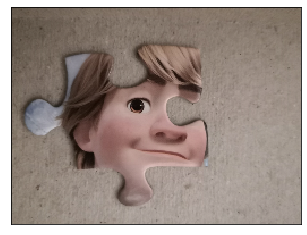

In [9]:
show_image(train_images[3])

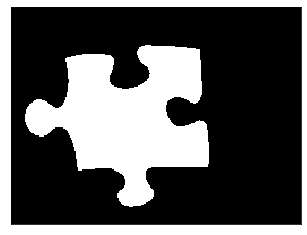

In [10]:
show_image(train_masks[3], cmap='gray')

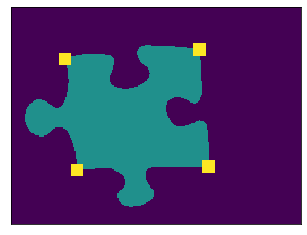

In [11]:
show_image(train_masks_corners[3])

# Pre-process data:
Create augmented training set (Includes pre-processing of images and masks)

In [12]:
def preprocess_image_data(train_images, train_masks, train_masks_corners,
                          validate_images, validate_masks, validate_masks_corners,
                          test_images=None, test_masks=None, test_masks_corners=None, num_classes=3):
    """Apply augmentation to training set, and one hot encode masks for model training and predictions"""

    augmented_data = []
    augmented_masks = []
    validate_images_ = []
    validate_masks_ = []
    test_images_ = []
    test_masks_ = []
    
    if num_classes == 3:
        train_masks = train_masks_corners
        validate_masks = validate_masks_corners
    
    # Augmented training data
    for train_image, train_mask in zip(train_images, train_masks):
        image_list, mask_list = get_augmented_lists(num_classes, train_image, train_mask)
        augmented_data += image_list
        augmented_masks += mask_list
    
    # Validation data
    for validate_image, validate_mask in zip(validate_images, validate_masks):
        validate_images_.append(np.expand_dims(normalise_data(validate_image), axis=0))
        validate_masks_.append(
                                tf.one_hot(
                                np.expand_dims(validate_mask.astype(np.int32), axis=0),
                                depth=num_classes,
                                dtype=tf.int32))
    # Optional testing data
    if test_images is not None:
        for test_image, test_mask in zip(test_images, test_masks):
            test_images_.append(np.expand_dims(normalise_data(test_image), axis=0))
            test_masks_.append(test_mask)
    
    # Create tf dataset
    training_data = tf.data.Dataset.from_tensor_slices((
        {
            'input_image': augmented_data
        },
        {
            'output_mask': augmented_masks
        }))

    validation_data = tf.data.Dataset.from_tensor_slices((
        {
            'input_image': validate_images_
        },
        {
            'output_mask': validate_masks_
        }))    
        
    return training_data, validation_data, test_images_, test_masks_

## VGG-16

The VGG16 model proposed was tested using the ImageNet data set, which contains over 15 million hand labeled high-resolution images, that belong to around 22-thousand categories. The model was trained for weeks, and pre-trained models are commonly available using deep learning APIs.

In [13]:
vgg16_pretrained = VGG16(include_top=False, weights='imagenet', input_shape=(192,256,3))
vgg16_pretrained.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 128, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 128, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 128, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 64, 128)       0     

## The U-Net architecture
U-Net was originally published as a convolutional network for biomedical image segmentation. The U-Net model was named after its U-shape that consists of two paths, which are commonly referred to in deep learning as the encoder- and decoder networks. U-Net's encoder captures the context of input images, and it contains a symmetric decoder that allows to localization using a technique called upsampling (fractional convolution or transposed convolution.)
<br><br>
![Unet](resources/Unet.PNG)


### VGG16-U-Net
The idea is to use the pre-trained VGG16 model as the encoder to a U-Net model, and also to construct a symmetric decoder network.

In [14]:
class VGGUnet(object):
    
    def __init__(self, input_shape=(192, 256, 3), num_classes=3, learning_rate=1e-4):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self._build_model(self.input_shape, self.num_classes)
        self.optimizer = Adam(learning_rate=learning_rate)
        self.model.compile(optimizer=self.optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        
    def _build_model(self, input_shape, num_classes):
        """Builds a UNet model from Keras' pretrained VGG16 model."""
        encoder = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
        encoder.layers[0]._name  = 'input_image'
        # Decoder block1, from Encoder output
        encoder_output = encoder.output
        conv_0 = Conv2D(512, 3, activation='relu', padding='same')(encoder_output)
        conv_0_up = Conv2DTranspose(256, 3, strides=2, activation='relu', padding='same')(conv_0)
        
        # Decoder block 1, concat block with encoder block 5
        concat_1 = concatenate([encoder.get_layer('block5_conv3').output, conv_0_up])
        conv_1 = Conv2D(512, 3, activation='relu', padding='same')(concat_1)
        conv_1_up =  Conv2DTranspose(256, 3, strides=2, activation='relu', padding='same')(conv_1)
        
        # Decoder block 2, concat block with encoder block 4
        concat_2 = concatenate([encoder.get_layer('block4_conv3').output, conv_1_up])
        conv_2 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat_2)
        conv_2_up =  Conv2DTranspose(256, 3, strides=2, activation='relu', padding='same')(conv_2)
        
        # Decoder block 3, concat block with encoder block 3
        concat_3 = concatenate([encoder.get_layer('block3_conv3').output, conv_2_up])
        conv_3 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat_3)
        conv_3_up =  Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same')(conv_3)
        
        # Decoder block 4, concat block with encoder block 2
        concat_4 = concatenate([encoder.get_layer('block2_conv2').output, conv_3_up])
        conv_4 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat_4)
        conv_4_up =  Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(conv_4)
        
        # Decoder block 5, concat block with encoder block 1
        concat_5 = concatenate([encoder.get_layer('block1_conv2').output, conv_4_up])
        conv_5 = Conv2D(32, 3, activation='relu', padding='same')(concat_5)
        
        outputs = Conv2D(num_classes, 1, activation='softmax', name='output_mask')(conv_5)
        
        return Model(inputs=encoder.layers[0].input, outputs=outputs, name='VGGUNet')
    
    def summary(self):
        print(self.model.summary())

    def train(self, training_data, validation_data, epochs):
        self.model.fit(training_data, validation_data=validation_data, epochs=epochs)
    
    def predict(self, X):
        return np.squeeze(self.model.predict(X))

def post_processing(fg_bg_pred, kernel_dims):
    """Apply morhpolical transformations of closing
    and opening"""
    kernel = np.ones((kernel_dims, kernel_dims),np.uint8)
    fg_bg_pred = cv2.morphologyEx(fg_bg_pred, cv2.MORPH_OPEN, kernel)
    fg_bg_pred = cv2.morphologyEx(fg_bg_pred, cv2.MORPH_CLOSE, kernel)
    return fg_bg_pred

def set_corner_segmentation(fg_bg_pred, corner_pred):
    result = fg_bg_pred.copy()
    corner_pred = (corner_pred > 0.5).astype(np.uint8)
    contours, _ = cv2.findContours(corner_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    areas = np.array([cv2.contourArea(contour) for contour in contours])
    # Draw a centered rectangle for the 4 largest contour areas
    for index in areas.argsort()[-4:][::-1]:
        x, y, w, h = cv2.boundingRect(contours[index])
        result = cv2.rectangle(result.astype(np.float32), (x, y),
                              (x + HYPER_PARAMS['CORNER_RECT_DIMS'][0],
                               y + HYPER_PARAMS['CORNER_RECT_DIMS'][1]), 2, -1)
    return result
        
def test_predictions(num_classes, vgg_unet, test_images, test_masks, morph_dims, plot=True):
    predict_count = 0
    total_score = 0
    for image, mask in zip(test_images, test_masks) :
        predict_count += 1
        pred = vgg_unet.predict(image)
        fg_bg_pred = pred[:, :, 0:2]
        fg_bg_pred = np.argmax(fg_bg_pred, axis=-1).astype(np.float32)
        fg_bg_pred = post_processing(fg_bg_pred, morph_dims)
        score = accuracy_score(fg_bg_pred.flatten(), mask.flatten().round())
        if num_classes == 3:
            corner_pred = pred[:, :, 2]
            final_image = set_corner_segmentation(fg_bg_pred, corner_pred)
        else:
            final_image = fg_bg_pred
        print("Prediction #{0}, accuracy:{1}%".format(predict_count, round(score *100, 2)) )
        total_score += score
        if plot:
            show_image(final_image)
            plt.show()
    print("Average accuracy:{0}%".format(round(total_score/predict_count *100, 2)) )  

In [15]:
vgg_unet = VGGUnet(learning_rate=HYPER_PARAMS['MODEL_LEARN_RATE'])

In [16]:
vgg_unet.summary()

Model: "VGGUNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 192, 256, 64) 1792        input_image[0][0]                
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 192, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 96, 128, 64)  0           block1_conv2[0][0]               
____________________________________________________________________________________________

# Background, Foreground and Corner Segmentation

This 3-class prediction produces slightly lower accuracy for background and foreground classification, <br>
hence a 2-class model is additionaly implemented, for a final accuracy to compare with the GMM.

<u> Class: </u> <br>
0 : Background <br>
1 : Foreground <br>
2 : Corner 


### Training

In [17]:
NUM_CLASSES = 3

In [18]:
training_data, validation_data, test_images_, test_masks_ = preprocess_image_data(
                                                            train_images, train_masks, train_masks_corners,\
                                                            validate_images, validate_masks, validate_masks_corners,\
                                                            test_images, test_masks, test_masks_corners,
                                                            num_classes = NUM_CLASSES)

In [19]:
vgg_unet = VGGUnet(learning_rate=HYPER_PARAMS['MODEL_LEARN_RATE'],
                   num_classes = NUM_CLASSES)

In [20]:
vgg_unet.train(training_data, validation_data, epochs=HYPER_PARAMS['MODEL_LEARN_EPOCHS'])

Epoch 1/20
136/136 [==============================] - 164s 1s/step - loss: 0.2016 - accuracy: 0.8832 - val_loss: 0.1080 - val_accuracy: 0.9423
Epoch 2/20
136/136 [==============================] - 162s 1s/step - loss: 0.0840 - accuracy: 0.9574 - val_loss: 0.0571 - val_accuracy: 0.9726
Epoch 3/20
136/136 [==============================] - 172s 1s/step - loss: 0.0538 - accuracy: 0.9743 - val_loss: 0.0449 - val_accuracy: 0.9783
Epoch 4/20
136/136 [==============================] - 173s 1s/step - loss: 0.0422 - accuracy: 0.9785 - val_loss: 0.0370 - val_accuracy: 0.9796
Epoch 5/20
136/136 [==============================] - 169s 1s/step - loss: 0.0307 - accuracy: 0.9821 - val_loss: 0.0272 - val_accuracy: 0.9837
Epoch 6/20
136/136 [==============================] - 172s 1s/step - loss: 0.0231 - accuracy: 0.9860 - val_loss: 0.0228 - val_accuracy: 0.9861
Epoch 7/20
136/136 [==============================] - 172s 1s/step - loss: 0.0197 - accuracy: 0.9879 - val_loss: 0.0207 - val_accuracy: 0.9872

### Test predictions

Prediction #1, accuracy:98.91%


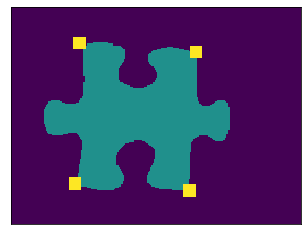

Prediction #2, accuracy:98.51%


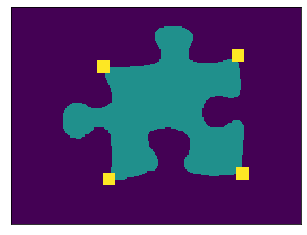

Prediction #3, accuracy:99.08%


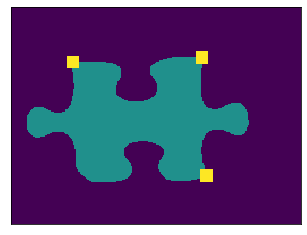

Prediction #4, accuracy:99.35%


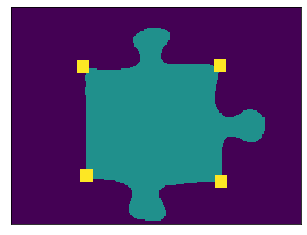

Prediction #5, accuracy:99.13%


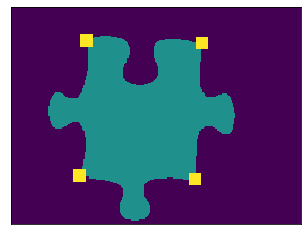

Prediction #6, accuracy:99.21%


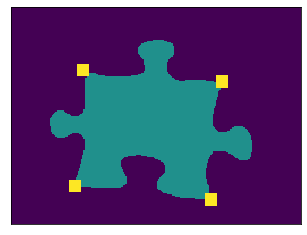

Prediction #7, accuracy:99.03%


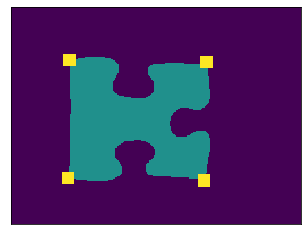

Average accuracy:99.03%


In [21]:
test_predictions(NUM_CLASSES, vgg_unet, test_images_, test_masks_, HYPER_PARAMS['MORPH_KERNEL_DIMS'])

# Background and Foreground
This 2-class prediction produces improved accuracy for background and foreground classification.

<u> Class: </u> <br>
0 : Background <br>
1 : Foreground <br>

## 6-Fold Cross-Validation
Since the data set is limited, cross-validation might be used to evaluate the skill of the UNet for the unseen test data. A 6-Fold method is used, which splits the data into 6 groups of 8 puzzle pieces each. The method is popular since it results in a less biased estimate of the model's skill than other methods. The procedure used follows:
- Shuffle the test set data randomly
- Split the data set randomly into the 6 groups (with 8 image data each.)
- Then for each of these groups
 - Assign the group as a test set
 - Use all the remaining groups as the training set
 - Fit the model on the training set and evaluate it using the test set
 - Compute the score and discard the model
- Model performance is then the mean value of all scores

In [24]:
def test_predictions_cv(num_classes, vgg_unet, test_images, test_masks, morph_dims, plot=True):
    predict_count = 0
    total_score = 0
    for image, mask in zip(test_images, test_masks) :
        predict_count += 1
        pred = vgg_unet.predict(image)
        fg_bg_pred = pred[:, :, 0:2]
        fg_bg_pred = np.argmax(fg_bg_pred, axis=-1).astype(np.float32)
        fg_bg_pred = post_processing(fg_bg_pred, morph_dims)
        score = accuracy_score(fg_bg_pred.flatten(), mask.flatten().round())
        if num_classes == 3:
            corner_pred = pred[:, :, 2]
            final_image = set_corner_segmentation(fg_bg_pred, corner_pred)
        else:
            final_image = fg_bg_pred
        print("Prediction #{0}, accuracy:{1}%".format(predict_count, round(score *100, 2)) )
        total_score += score
        if plot:
            show_image(final_image)
            plt.show()
    print("Average accuracy:{0}%".format(round(total_score/predict_count *100, 2)) )  
    return round(total_score/predict_count *100, 2)

In [25]:
def cross_val_manager(folds = 6):
    #initialize accuracy list
    acc = []
    
    # copy the data
    data_imgs = DATA_IMGS.copy()
    data_msks = DATA_MSKS.copy()
    
    #create groups
    #create a random array containing the index of each img number in the data set
    #each row of this array will be a group
    img_indices = np.random.choice(np.arange(0, data_imgs.shape[0]), replace=False, size=(folds, int(data_imgs.shape[0]/folds)))
    
    
    #main loop that selects one group of images as the test set and the remainder as the training sets
    for i in range(img_indices.shape[0]):
        print('Fold: {}'.format(i))
        training_indices = []
        testing_indices = img_indices[i]
        for row in range(img_indices.shape[0]):

            if row != i:
                #print('row: {}'.format(row))
                training_indices.append(list(img_indices[row]))
        training_indices = np.asarray(training_indices)
        #print('\ntest: {}'. format(testing_indices))
        #print('\ntrain: {}'.format(training_indices))

        #flatten the array
        train_indices = training_indices.flatten()
        
        #get training imgs and masks
        train_imgs = np.array([data_imgs[i] for i in train_indices])
        train_msks = np.array([data_msks[j] for j in train_indices])
        #train_masks_corners = get_corner_targets(DATA_CORNERS, data_msks, train_indices)
        
        #get test imgs and masks
        test_imgs = np.array([data_imgs[i] for i in testing_indices])
        test_msks = np.array([data_msks[j] for j in testing_indices])
        #test_masks_corners = get_corner_targets(DATA_CORNERS, test_msks, testing_indices)
        
        #define number of classes
        NUM_CLASSES = 3
        
        augmented_data = []
        augmented_masks = []
        test_images_ = []
        test_masks_ = []

        # Augmented training data
        for train_image, train_mask in zip(train_imgs, train_msks):
            image_list, mask_list = get_augmented_lists(NUM_CLASSES, train_image, train_mask)
            augmented_data += image_list
            augmented_masks += mask_list
            
        # Optional testing data
        if test_imgs is not None:
            for test_image, test_mask in zip(test_imgs, test_msks):
                test_images_.append(np.expand_dims(normalise_data(test_image), axis=0))
                test_masks_.append(test_mask)
        
        # Create tf dataset
        training_data = tf.data.Dataset.from_tensor_slices((
            {
                'input_image': augmented_data
            },
            {
                'output_mask': augmented_masks
            }))        
        
        #Create model
        vgg_unet = VGGUnet(learning_rate=HYPER_PARAMS['MODEL_LEARN_RATE'],
                   num_classes = NUM_CLASSES)
        
        #Train Model with training group
        vgg_unet.train(training_data, [], epochs=HYPER_PARAMS['MODEL_LEARN_EPOCHS'])
        
        #Test Model with test group
        group_acc = test_predictions_cv(NUM_CLASSES, vgg_unet, test_images_, test_masks_, HYPER_PARAMS['MORPH_KERNEL_DIMS'])
        
        #append accuracy to acc list
        acc.append(group_acc)
        
    print('\nThe accuracy scores achieved for each fold:')
    print(acc)
    
    final_acc = sum(acc)/len(acc)
    print('\nThe final accuracy of the system: {}'.format(final_acc))

Fold: 0
Epoch 1/20
160/160 [==============================] - 172s 1s/step - loss: 0.3837 - accuracy: 0.7788
Epoch 2/20
160/160 [==============================] - 184s 1s/step - loss: 0.0703 - accuracy: 0.9585
Epoch 3/20
160/160 [==============================] - 190s 1s/step - loss: 0.0360 - accuracy: 0.9787
Epoch 4/20
160/160 [==============================] - 197s 1s/step - loss: 0.0243 - accuracy: 0.9855
Epoch 5/20
160/160 [==============================] - 204s 1s/step - loss: 0.0193 - accuracy: 0.9883
Epoch 6/20
160/160 [==============================] - 203s 1s/step - loss: 0.0166 - accuracy: 0.9898
Epoch 7/20
160/160 [==============================] - 208s 1s/step - loss: 0.0148 - accuracy: 0.9909
Epoch 8/20
160/160 [==============================] - 203s 1s/step - loss: 0.0134 - accuracy: 0.9917
Epoch 9/20
160/160 [==============================] - 196s 1s/step - loss: 0.0123 - accuracy: 0.9924
Epoch 10/20
160/160 [==============================] - 188s 1s/step - loss: 0.0114 

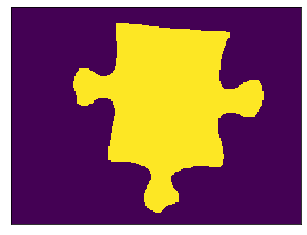

Prediction #2, accuracy:99.56%


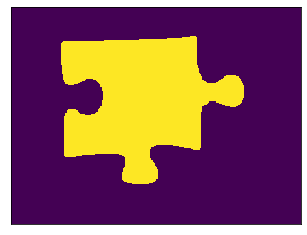

Prediction #3, accuracy:99.49%


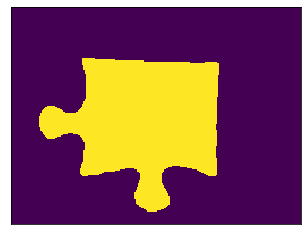

Prediction #4, accuracy:99.62%


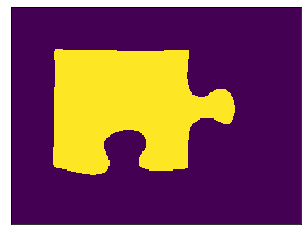

Prediction #5, accuracy:99.24%


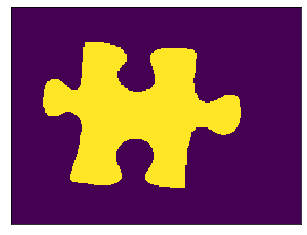

Prediction #6, accuracy:99.47%


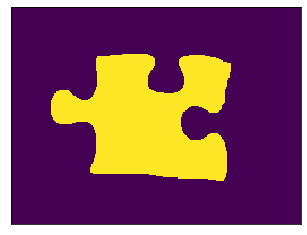

Prediction #7, accuracy:99.3%


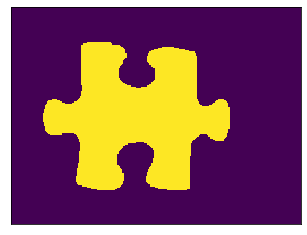

Prediction #8, accuracy:99.4%


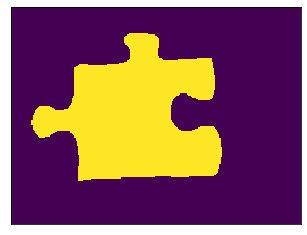

Average accuracy:99.39%
Fold: 1
Epoch 1/20
160/160 [==============================] - 196s 1s/step - loss: 0.2336 - accuracy: 0.8579
Epoch 2/20
160/160 [==============================] - 192s 1s/step - loss: 0.0514 - accuracy: 0.9700
Epoch 3/20
160/160 [==============================] - 198s 1s/step - loss: 0.0252 - accuracy: 0.9852
Epoch 4/20
160/160 [==============================] - 201s 1s/step - loss: 0.0219 - accuracy: 0.9870
Epoch 5/20
160/160 [==============================] - 207s 1s/step - loss: 0.0172 - accuracy: 0.9896
Epoch 6/20
160/160 [==============================] - 208s 1s/step - loss: 0.0153 - accuracy: 0.9907
Epoch 7/20
160/160 [==============================] - 207s 1s/step - loss: 0.0135 - accuracy: 0.9916
Epoch 8/20
160/160 [==============================] - 210s 1s/step - loss: 0.0123 - accuracy: 0.9924
Epoch 9/20
160/160 [==============================] - 199s 1s/step - loss: 0.0112 - accuracy: 0.9930
Epoch 10/20
160/160 [==============================] - 194s

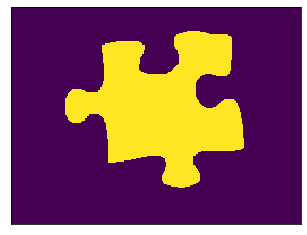

Prediction #2, accuracy:99.21%


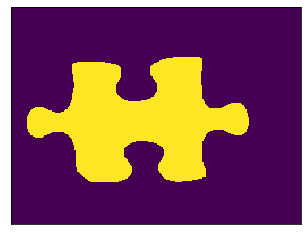

Prediction #3, accuracy:99.38%


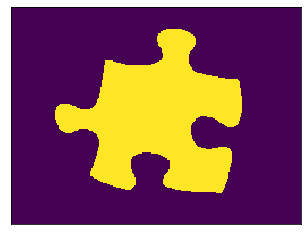

Prediction #4, accuracy:99.16%


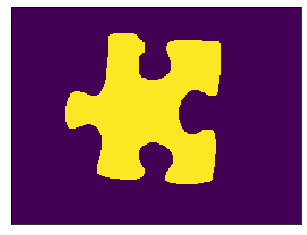

Prediction #5, accuracy:99.44%


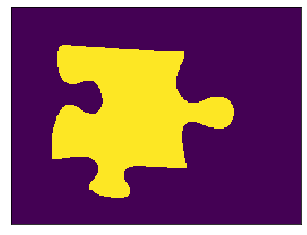

Prediction #6, accuracy:98.86%


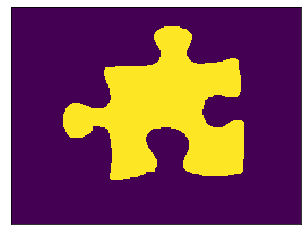

Prediction #7, accuracy:99.56%


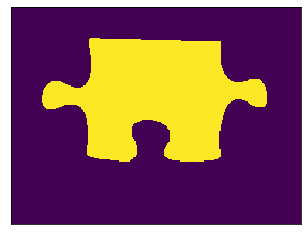

Prediction #8, accuracy:99.04%


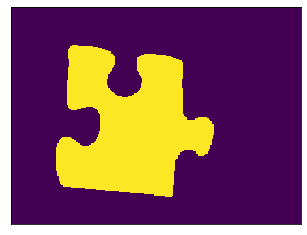

Average accuracy:99.25%
Fold: 2
Epoch 1/20
160/160 [==============================] - 213s 1s/step - loss: 0.3993 - accuracy: 0.7697
Epoch 2/20
160/160 [==============================] - 217s 1s/step - loss: 0.0868 - accuracy: 0.9488
Epoch 3/20
160/160 [==============================] - 213s 1s/step - loss: 0.0361 - accuracy: 0.9790
Epoch 4/20
160/160 [==============================] - 216s 1s/step - loss: 0.0246 - accuracy: 0.9855
Epoch 5/20
160/160 [==============================] - 216s 1s/step - loss: 0.0193 - accuracy: 0.9885
Epoch 6/20
160/160 [==============================] - 216s 1s/step - loss: 0.0166 - accuracy: 0.9899
Epoch 7/20
160/160 [==============================] - 219s 1s/step - loss: 0.0149 - accuracy: 0.9909
Epoch 8/20
160/160 [==============================] - 218s 1s/step - loss: 0.0135 - accuracy: 0.9917
Epoch 9/20
160/160 [==============================] - 217s 1s/step - loss: 0.0125 - accuracy: 0.9923
Epoch 10/20
160/160 [==============================] - 218s

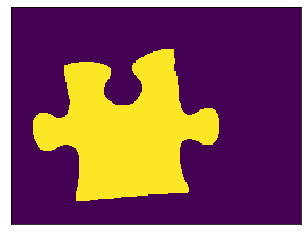

Prediction #2, accuracy:99.28%


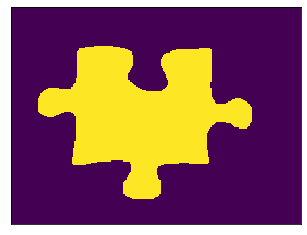

Prediction #3, accuracy:99.56%


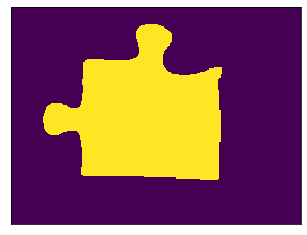

Prediction #4, accuracy:99.5%


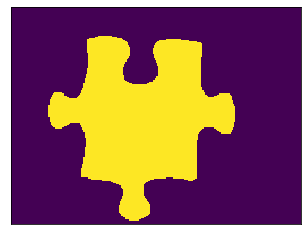

Prediction #5, accuracy:99.46%


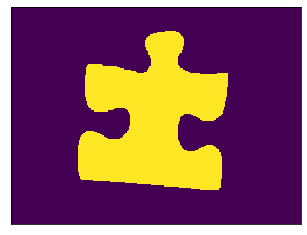

Prediction #6, accuracy:99.48%


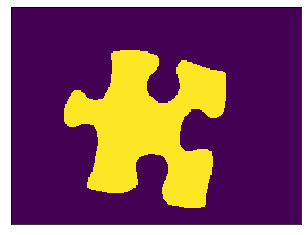

Prediction #7, accuracy:99.49%


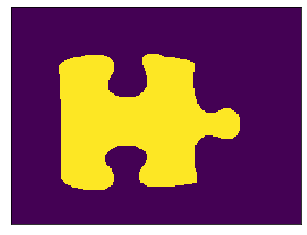

Prediction #8, accuracy:99.33%


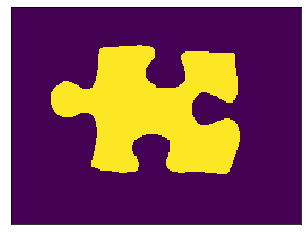

Average accuracy:99.46%
Fold: 3
Epoch 1/20
160/160 [==============================] - 211s 1s/step - loss: 0.4359 - accuracy: 0.7350
Epoch 2/20
160/160 [==============================] - 215s 1s/step - loss: 0.0586 - accuracy: 0.9664
Epoch 3/20
160/160 [==============================] - 216s 1s/step - loss: 0.0270 - accuracy: 0.9843
Epoch 4/20
160/160 [==============================] - 217s 1s/step - loss: 0.0196 - accuracy: 0.9883
Epoch 5/20
160/160 [==============================] - 219s 1s/step - loss: 0.0161 - accuracy: 0.9903
Epoch 6/20
160/160 [==============================] - 215s 1s/step - loss: 0.0137 - accuracy: 0.9917
Epoch 7/20
160/160 [==============================] - 215s 1s/step - loss: 0.0120 - accuracy: 0.9926
Epoch 8/20
160/160 [==============================] - 216s 1s/step - loss: 0.0108 - accuracy: 0.9933
Epoch 9/20
160/160 [==============================] - 216s 1s/step - loss: 0.0102 - accuracy: 0.9937
Epoch 10/20
160/160 [==============================] - 218s

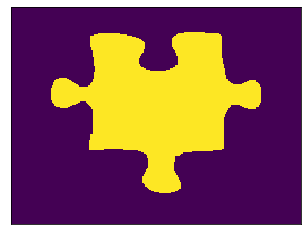

Prediction #2, accuracy:99.35%


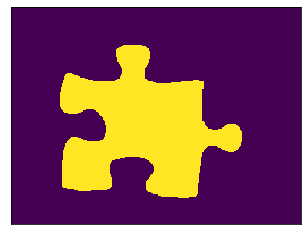

Prediction #3, accuracy:99.31%


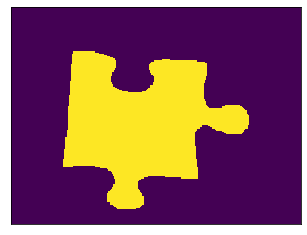

Prediction #4, accuracy:99.15%


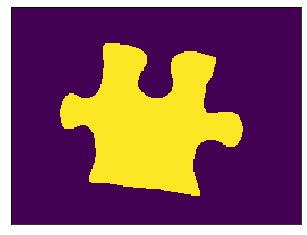

Prediction #5, accuracy:99.5%


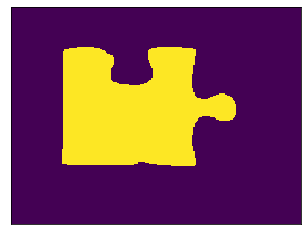

Prediction #6, accuracy:99.24%


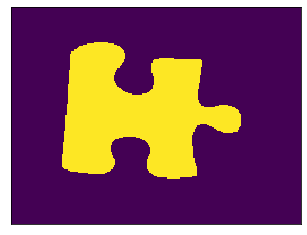

Prediction #7, accuracy:99.49%


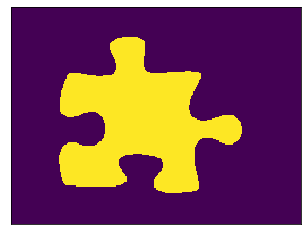

Prediction #8, accuracy:99.09%


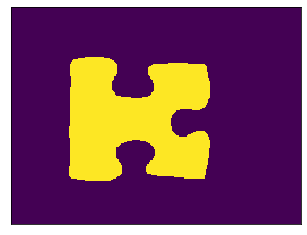

Average accuracy:99.29%
Fold: 4
Epoch 1/20
160/160 [==============================] - 194s 1s/step - loss: 0.1887 - accuracy: 0.8761
Epoch 2/20
160/160 [==============================] - 193s 1s/step - loss: 0.0384 - accuracy: 0.9776
Epoch 3/20
160/160 [==============================] - 196s 1s/step - loss: 0.0264 - accuracy: 0.9845
Epoch 4/20
160/160 [==============================] - 196s 1s/step - loss: 0.0180 - accuracy: 0.9892
Epoch 5/20
160/160 [==============================] - 197s 1s/step - loss: 0.0149 - accuracy: 0.9909
Epoch 6/20
160/160 [==============================] - 196s 1s/step - loss: 0.0130 - accuracy: 0.9920
Epoch 7/20
160/160 [==============================] - 196s 1s/step - loss: 0.0117 - accuracy: 0.9928
Epoch 8/20
160/160 [==============================] - 196s 1s/step - loss: 0.0106 - accuracy: 0.9935
Epoch 9/20
160/160 [==============================] - 196s 1s/step - loss: 0.0098 - accuracy: 0.9940
Epoch 10/20
160/160 [==============================] - 195s

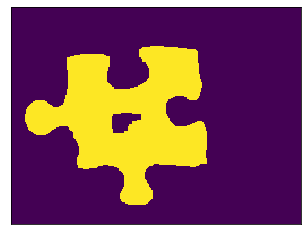

Prediction #2, accuracy:99.37%


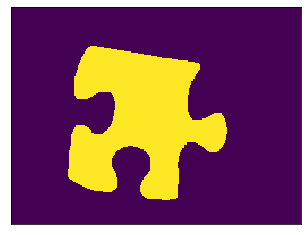

Prediction #3, accuracy:99.16%


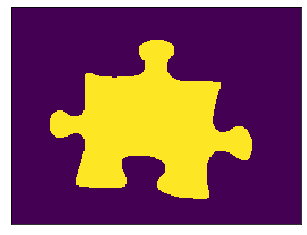

Prediction #4, accuracy:99.08%


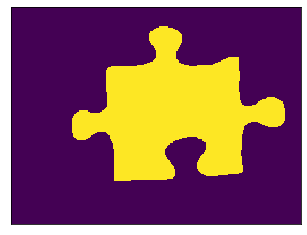

Prediction #5, accuracy:99.11%


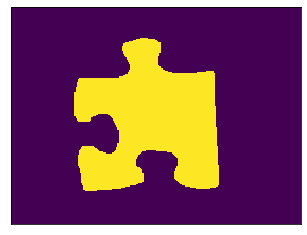

Prediction #6, accuracy:98.84%


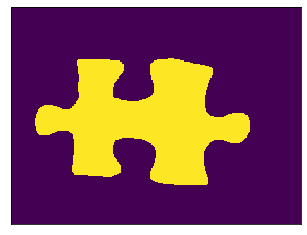

Prediction #7, accuracy:99.34%


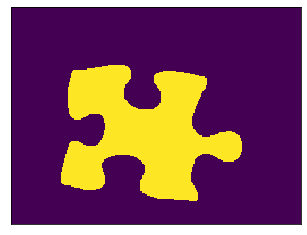

Prediction #8, accuracy:99.43%


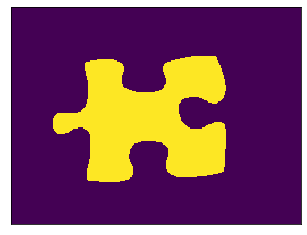

Average accuracy:99.02%
Fold: 5
Epoch 1/20
160/160 [==============================] - 192s 1s/step - loss: 0.6072 - accuracy: 0.6252
Epoch 2/20
160/160 [==============================] - 195s 1s/step - loss: 0.0466 - accuracy: 0.9734
Epoch 3/20
160/160 [==============================] - 197s 1s/step - loss: 0.0270 - accuracy: 0.9841
Epoch 4/20
160/160 [==============================] - 196s 1s/step - loss: 0.0218 - accuracy: 0.9870
Epoch 5/20
160/160 [==============================] - 195s 1s/step - loss: 0.0177 - accuracy: 0.9893
Epoch 6/20
160/160 [==============================] - 196s 1s/step - loss: 0.0151 - accuracy: 0.9908
Epoch 7/20
160/160 [==============================] - 196s 1s/step - loss: 0.0134 - accuracy: 0.9918
Epoch 8/20
160/160 [==============================] - 195s 1s/step - loss: 0.0121 - accuracy: 0.9926
Epoch 9/20
160/160 [==============================] - 194s 1s/step - loss: 0.0110 - accuracy: 0.9932
Epoch 10/20
160/160 [==============================] - 192s

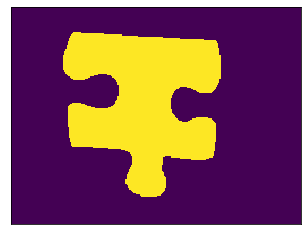

Prediction #2, accuracy:99.2%


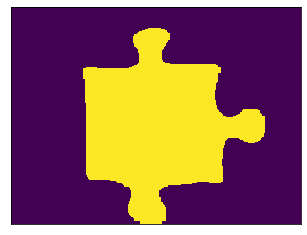

Prediction #3, accuracy:99.28%


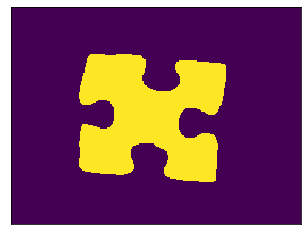

Prediction #4, accuracy:99.65%


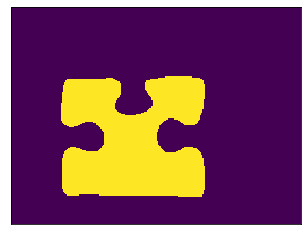

Prediction #5, accuracy:98.99%


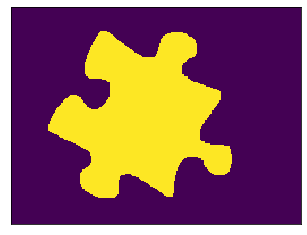

Prediction #6, accuracy:99.34%


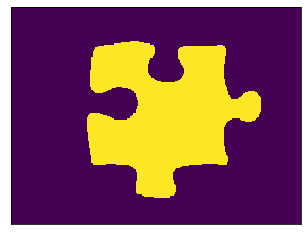

Prediction #7, accuracy:99.08%


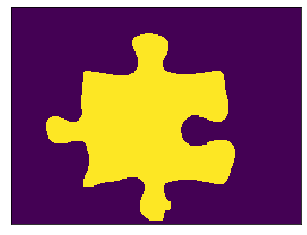

Prediction #8, accuracy:99.22%


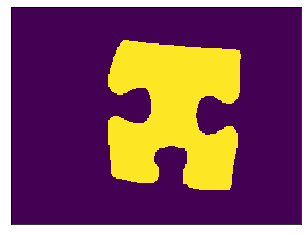

Average accuracy:99.27%

The accuracy scores achieved for each fold:
[99.39, 99.25, 99.46, 99.29, 99.02, 99.27]

The final accuracy of the system: 99.27999999999999


In [26]:
cross_val_manager(folds = 6)